Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [12]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
import numpy as np
from numpy.random import normal
from collections import defaultdict
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

## The *Nim* and *Nimply* classes

In [13]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [14]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

## Sample (and silly) startegies 

In [15]:
def all_possible_moves(state: Nim) -> list:
    all_moves = []
    for row in [r for r, c in enumerate(state.rows) if c > 0]:
        upper_bound_for = (
            min(state.rows[row], state._k) + 1
            if state._k
            else state.rows[row] + 1
        )
        for obj_to_take in range(1, upper_bound_for):
            all_moves.append(Nimply(row, obj_to_take))
    return all_moves

In [16]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    return random.choice(all_possible_moves(state))

In [17]:
# 2.1 agent in slides
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [
        (r, o)
        for r, c in enumerate(state.rows)
        for o in range(1, min(c, state._k) + 1 if state._k else c + 1)
    ]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))

In [18]:
# nim_sum: function often used in the mathematical analysis of the game to find winning strategies.
# https://www.archimedes-lab.org/How_to_Solve/Win_at_Nim.html#:~:text=To%20win%20at%20Nim%2Dgame,error%20in%20order%20to%20win.
def nim_sum(state: Nim) -> int:
    # tmp: for each row, transform the number of object in that row to its binary form (width 32 bit), binary as a tuple of bits
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int(
        "".join(str(_) for _ in xor), base=2
    )  # convert the string of bit in its integer form


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (
        Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)
    ):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [
        ply for ply, ns in analysis["possible_moves"].items() if ns != 0
    ]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply

## Functions needed to play and plot

In [19]:
def plot(
    wins_over_games_list: list, n_games, player0: callable, player1: callable
):
    # PLOT
    games_list = range(1, n_games + 1)
    wins_0_over_games_list = (
        np.array([x[0] for x in wins_over_games_list])
        / np.array(games_list)
        * 100
    )
    wins_1_over_games_list = (
        np.array([x[1] for x in wins_over_games_list])
        / np.array(games_list)
        * 100
    )

    plt.stackplot(
        games_list,
        wins_0_over_games_list,
        wins_1_over_games_list,
        colors=["b", "r"],
        labels=[
            f"Player 0 [{player0.__name__}]",
            f"Player 1 [{player1.__name__}]",
        ],
    )
    plt.legend(loc="lower right")
    plt.xlabel("Game")
    plt.ylabel("% Wins")


def simplified_match_for_new_agents(
    agent: callable,
    opponent: callable,
    nim_rows: int = 5,
    nim_k: int = None,
    n_games: int = 500,
) -> list:
    logging.getLogger().setLevel(logging.INFO)

    # toss a coin for who starts
    if random.random() > 0.5:
        strategy = (agent, opponent)
        num_agent = 0
    else:
        strategy = (opponent, agent)
        num_agent = 1

    wins_agent = 0  # wins of agent
    wins_opponent = 0  # wins of opponents

    # useful for plotting only
    wins_over_games_list = (
        []
    )  # for each game [(win_0, win_1), (win_0, win_1), ...]

    with tqdm(total=n_games, desc="Game: ") as pbar:
        for _ in range(n_games):
            nim = Nim(nim_rows)
            # logging.info(f"init : {nim}")
            player = 1
            while nim:
                ply = strategy[player](nim)
                # logging.info(f"ply: player {player} plays {ply}")
                nim.nimming(ply)
                # logging.info(f"status: {nim}")
                player = 1 - player
            # logging.info(f"status: Player {player} won!")
            if player == num_agent:
                wins_agent += 1
            else:
                wins_opponent += 1
            # update stats for plot
            wins_over_games_list.append((wins_agent, wins_opponent))
            pbar.update(1)

    print(f"{int(wins_agent/n_games *100)}% of wins")
    plot(wins_over_games_list, n_games, agent, opponent)

## Evolution strategies

### 2.2 Evolved agent

In [20]:
# for convienience and for code reusability we will implement this code as a class
class Ev_strat_1:
    def __init__(self, c_sigma: int = 1):
        self.c_sigma = c_sigma
        self.__name__ = "Ev_strat_1"

    def __call__(self, state: Nim) -> Nimply:
        cooked = dict()
        created_off = 0
        # generate lambda new states, porportional to number of object in row
        for idx_row, row in enumerate(state.rows):
            # do C*row tweaks on this row
            n_tweaks = 2 * row
            created_off += n_tweaks
            for _ in range(n_tweaks):
                n_obj_offspring = self.tweak(row)
                tmp = deepcopy(state)
                ply = Nimply(idx_row, n_obj_offspring)
                try:
                    tmp.nimming(
                        ply
                    )  # nimming already checks if currecnt move (ply) and current state are valid
                    if ply.num_objects > 0 and ply not in cooked.keys():
                        # this is the fitness function that evaluates the cooked[ply] move.
                        cooked[ply] = nim_sum(tmp)
                except:
                    pass

        # select best choice in cooked[ply].
        if cooked:
            best_ply, _ = max(cooked.items(), key=lambda t: t[1])
            # conto il numero di soluzioni "buone" trovate, se sono meno del 20% allora abbasso il sigma.
            # abbasso il sigma perchè alzandolo ci sono più probabilità di creare soluzioni fuori range.
            nim_diff_from_0 = 0
            for it in cooked.items():
                if it[1] != 0:
                    nim_diff_from_0 += 1
            if nim_diff_from_0 / created_off <= 0.2:
                self.c_sigma /= 1.1
            else:
                self.c_sigma *= 1.1
        else:  # if no cooked move, then random move
            best_ply = pure_random(state)

        return best_ply

    def tweak(self, item: int) -> list:
        starting_move = item / 2  # for now we will take the real num.
        # offspring = round(normal(loc=starting_move, scale=C_sigma * starting_move))
        offspring = round(
            normal(loc=starting_move, scale=self.c_sigma * starting_move)
        )
        # offsprings = round(normal(loc=starting_move, scale=C_sigma*starting_move, size=(C*item)))
        return offspring

### 2.2.1 Professor agent

In [21]:
# This function takes as input:
# The current state of the game.
# A list of possible moves to do in this current state.
# The number of games to play against the opponent.
# The opponent to play against.
# It returns as output:
# a dictionary composed of all the first moves made with their number of wins
def fitness(
    state: Nim, moves: list, n_games: int, adversarial_strategy: callable
) -> dict:
    first_moves = defaultdict(int)
    # we will play approximately for each move 10 games in which that move will be the starting one.
    for first_move in moves:
        for _ in range(n_games // len(moves)):
            nim = deepcopy(state)
            strategy = (pure_random, adversarial_strategy)
            # player is 0 because we are the one that moves.
            player = 0
            first_move = random.choice(moves)
            is_first = True
            while nim:
                if is_first:
                    ply = first_move
                    is_first = False
                else:
                    ply = strategy[player](nim)
                nim.nimming(ply)
                player = 1 - player
            # add 1 to the first move value if we won with that move, 0 else
            first_moves[first_move] += 1 if player == 0 else 0
    return first_moves


def es2(state: Nim) -> Nimply:
    all_moves = all_possible_moves(state)
    n_games = len(all_moves) * 10
    first_moves = fitness(state, all_moves, n_games, pure_random)
    best_move, _ = max(first_moves.items(), key=lambda i: i[1])
    return best_move


# This es is a boost of es2:
# Cheoosen the K best moves against pure_random,
# it plays them against optimal and test which one is better


def es2_boosted(state: Nim) -> Nimply:
    all_moves = all_possible_moves(state)
    n_games = len(all_moves) * 5
    first_moves = fitness(state, all_moves, n_games, pure_random)
    # get top-K moves against pure_random
    K = 4
    first_moves = first_moves.items()
    top_K_first_moves = sorted(first_moves, key=lambda t: -t[1])[:K]
    top_K_first_moves = [move[0] for move in top_K_first_moves]

    n_games = K * 10
    moves_wins_against_optimal = fitness(
        state, top_K_first_moves, n_games, optimal
    )
    best_move, _ = max(moves_wins_against_optimal.items(), key=lambda i: i[1])

    return best_move

## Oversimplified match

Game: 100%|██████████| 500/500 [00:07<00:00, 62.96it/s]


89% of wins


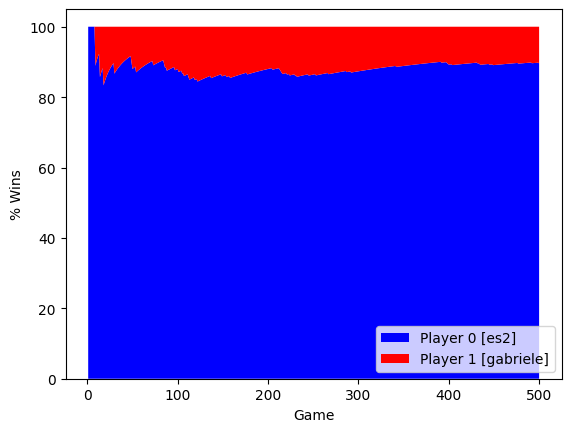

In [24]:
N_GAMES = 500
ev_strat_1 = Ev_strat_1()
agent = es2
opponent = gabriele
simplified_match_for_new_agents(
    agent=agent, opponent=opponent, nim_rows=5, k=4, n_games=N_GAMES
)